In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
users['creation_time'] = pd.to_datetime(users['creation_time'])
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [3]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [4]:
#inpute 0 for null values
for a in ['last_session_creation_time','invited_by_user_id']:
    users.loc[users[a].isnull(),a] = 0   

In [5]:
user_eng = pd.read_csv('takehome_user_engagement.csv')
user_eng['time_stamp'] = pd.to_datetime(user_eng['time_stamp'])
user_eng = user_eng.sort_values(['user_id','time_stamp'])
print(user_eng.shape)
user_eng.head(2)

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [6]:
user_eng.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [7]:
#check for dups
dupcheck = user_eng.groupby(['time_stamp','user_id']).sum()
dupcheck['visited'].value_counts()
#No duplicates found

1    207917
Name: visited, dtype: int64

### Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period...
<br>

In [8]:
import datetime
#make delayed date
delayed3 = user_eng['time_stamp'][0:len(user_eng)-2]
fakedate = datetime.datetime(2014,4,5)
delayed3 = [fakedate,fakedate] + list(delayed3)
user_eng['delayed3'] = delayed3
#subtracted dates
user_eng['timeperiod'] = (user_eng['time_stamp'] - user_eng['delayed3'])
user_eng['timeperiod'] = user_eng['timeperiod'].map(lambda x: x.days)
#make delayed user
delayed_user = user_eng['user_id'][0:len(user_eng)-2]
fakeuser = 1
delayed_user = [fakeuser,fakeuser] + list(delayed_user)
user_eng['delayed_user'] = delayed_user
user_eng.head()

,time_stamp,user_id,visited,delayed3,timeperiod,delayed_user
0,2014-04-22 03:53:30,1,1,2014-04-05 00:00:00,17,1
1,2013-11-15 03:45:04,2,1,2014-04-05 00:00:00,-141,1
2,2013-11-29 03:45:04,2,1,2014-04-22 03:53:30,-145,1
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,24,2
4,2013-12-25 03:45:04,2,1,2013-11-29 03:45:04,26,2


In [9]:
#make conditions
cond1 = user_eng['timeperiod'] <= 7
cond2 = user_eng['user_id'] == user_eng['delayed_user']

#make adopted user column
user_eng['adopted_user'] = 0
user_eng.loc[cond1&cond2,'adopted_user'] = 1

#get dataframe of adopted user ids
adoptedlog = user_eng.loc[user_eng['adopted_user']==1]
adoptedusers = pd.DataFrame(adoptedlog['user_id'].unique(),columns=['object_id'])
adoptedusers['adopted']=1
adoptedusers.head()


,object_id,adopted
0,2,1
1,10,1
2,20,1
3,33,1
4,42,1


In [10]:
#merge adopted user ids onto user dataframe
users = users.merge(adoptedusers,'left')
users['adopted'] = users['adopted'].fillna(0)
users['adopted'] = users['adopted'].astype(int)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


# identify which factors predict future user adoption

### Exploratory Analysis

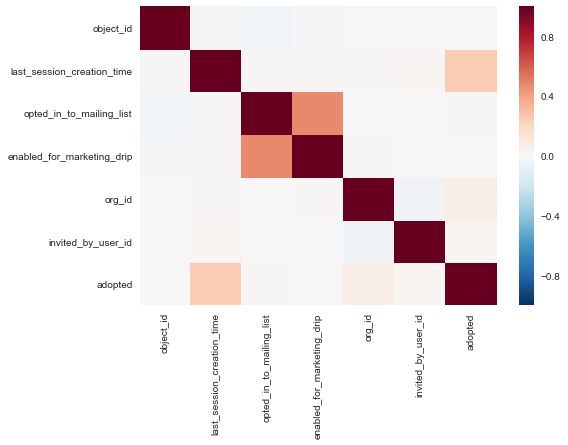

In [11]:
import seaborn as sns
correl = users.corr()
sns.heatmap(correl)

### We see that 'last session creation time' and 'org_id' are the only variables correlated with 'adopted'
### a faint correlation with mailing list also

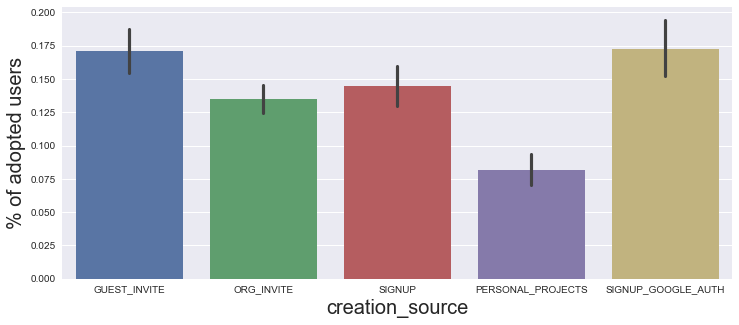

In [12]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot('creation_source','adopted',data=users)
plt.ylabel('% of adopted users',fontsize=20)
plt.xlabel('creation_source',fontsize=20)

### We see that the lowest is for 'PERSONAL_PROJECTS' (those who were invited to join another user's personal workspace)

In [13]:
##Organizations with the most adopted users
newdf = users.groupby('org_id').sum()
newdf.sort_values('adopted',ascending=False).head()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,adopted
org_id,,,,,,
4,887049,1.676885e+11,45,25,492313.0,17
1,1336395,2.366573e+11,45,20,614650.0,16
7,678598,1.215479e+11,29,23,286736.0,16
2,1244515,2.064086e+11,36,27,637731.0,15
13,453667,6.923729e+10,22,16,253007.0,14


In [14]:
##Invited User_Ids with the most adopted users
newdf = users.groupby('invited_by_user_id').sum()
newdf.sort_values('adopted',ascending=False).head()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted
invited_by_user_id,,,,,,
0.0,33690487,5.581521e+12,1375,829,805835,713
10628.0,63151,1.101889e+10,3,0,820,4
2354.0,46190,1.112954e+10,0,0,600,4
730.0,54529,1.112081e+10,4,1,1080,3
7358.0,20759,5.544973e+09,0,0,1380,3


### Modeling

In [15]:
#make creation source dictionary
diction = dict(zip(users['creation_source'].unique(),np.arange(0,len(users['creation_source'].unique()))))

#change variable
users['creation_source'] = users['creation_source'].apply(lambda x: diction[x])

def formatdate(df,col):
    df[col + '_' 'year'] = df[col].dt.year
    df[col + '_' 'month'] = df[col].dt.month
    df[col + '_' 'day'] = df[col].dt.day
    df[col + '_' 'hour'] = df[col].dt.hour
    
formatdate(users,'creation_time')

In [117]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight={0:.000001,1:10
                                         })

In [118]:
from sklearn.model_selection import train_test_split
X = users.drop(['adopted','email','name','object_id','creation_time','last_session_creation_time'],axis=1)
y = users['adopted']

X_train,X_test,y_train,y_test = train_test_split(X,y)


rf.fit(X_train,y_train)
results = pd.DataFrame({'predicted': rf.predict(X_test),
             'real': y_test})

results['correct']= results['predicted']==results['real']

#check accuracy
from sklearn.metrics import accuracy_score, recall_score
print('Accuracy: {:.2%}'.format(accuracy_score(results['real'],results['predicted'])))
print('Recall: {:.2%}'.format(recall_score(results['real'],results['predicted'])))

Accuracy: 78.07%
Recall: 19.68%


In [120]:
thedf = pd.DataFrame({'features':X_test.columns,
    'importances':rf.feature_importances_})

thedf.sort_values('importances',ascending=False)

,features,importances
3,org_id,0.297951
7,creation_time_day,0.195759
8,creation_time_hour,0.187045
4,invited_by_user_id,0.112870
6,creation_time_month,0.091118
0,creation_source,0.053651
1,opted_in_to_mailing_list,0.022855
2,enabled_for_marketing_drip,0.020269
5,creation_time_year,0.018482


## Recap

    - We see that 'last session creation time' and 'org_id' are the variables correlated with 'adopted'. There is a very faint correlation with mailing list also.
    - We see that the lowest % of adopted users is for 'PERSONAL_PROJECTS' (those who were invited to join another user's personal workspace).
    - Our model shows org_id as the most important feature, but our recall metric is so bad that this model is unreliable.  We should look to acquire other data to figure out a better predictor of adopted users